In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [36]:


# Define the CNN model architecture
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(4*4*256, 1024)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.view(-1, 4*4*256)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

model = MyCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Set the number of epochs to train
num_epochs = 50
batch_size = 64

# Initialize lists to store the training loss and accuracy
train_loss = []
train_acc = []

# Train the CNN model
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i % 100 == 99:
            # Compute the training loss and accuracy for this epoch
            epoch_loss = running_loss / ((i+1) * batch_size)
            epoch_acc = running_corrects.double() / ((i+1) * batch_size)

            # Append the loss and accuracy to the lists
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)

            # Print the training loss and accuracy for this epoch
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch+1, num_epochs, i+1, len(trainset)//batch_size, epoch_loss, epoch_acc*100))

Epoch [1/50], Step [100/781], Loss: 4.4246, Accuracy: 48.69%
Epoch [1/50], Step [200/781], Loss: 4.3133, Accuracy: 60.52%
Epoch [1/50], Step [300/781], Loss: 4.2405, Accuracy: 68.04%
Epoch [2/50], Step [100/781], Loss: 3.9870, Accuracy: 93.44%
Epoch [2/50], Step [200/781], Loss: 3.9690, Accuracy: 95.23%
Epoch [2/50], Step [300/781], Loss: 3.9458, Accuracy: 97.61%
Epoch [3/50], Step [100/781], Loss: 3.8531, Accuracy: 107.14%
Epoch [3/50], Step [200/781], Loss: 3.8454, Accuracy: 107.69%
Epoch [3/50], Step [300/781], Loss: 3.8281, Accuracy: 109.49%
Epoch [4/50], Step [100/781], Loss: 3.7632, Accuracy: 116.00%
Epoch [4/50], Step [200/781], Loss: 3.7569, Accuracy: 116.59%
Epoch [4/50], Step [300/781], Loss: 3.7547, Accuracy: 116.78%
Epoch [5/50], Step [100/781], Loss: 3.7233, Accuracy: 119.64%
Epoch [5/50], Step [200/781], Loss: 3.7106, Accuracy: 121.02%
Epoch [5/50], Step [300/781], Loss: 3.7097, Accuracy: 121.17%
Epoch [6/50], Step [100/781], Loss: 3.6879, Accuracy: 123.28%
Epoch [6/50], 

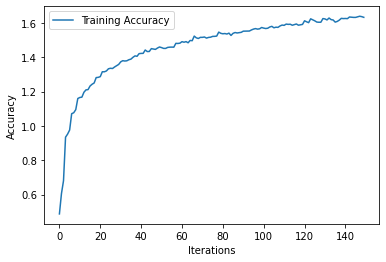

In [37]:
# plot training accuracy
plt.plot(torch.Tensor(train_acc), label='Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

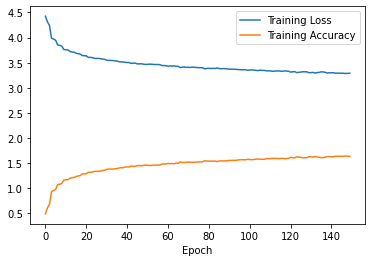

In [38]:
# Plot the training loss and accuracy
plt.plot(train_loss, label='Training Loss')
plt.plot(torch.Tensor(train_acc), label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [39]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %
